<a href="https://colab.research.google.com/github/adiba82001/CSE475_project/blob/main/Final_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
#math operations
import numpy as np
#machine learning
import cv2
import os
from random import shuffle
from tqdm import tqdm
import random
#for opening and loading image
from PIL import Image
#for preprocessing
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
#Doing One hot encoding as classifier has multiple classes
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from random import shuffle
#For augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#MobileNetV2 model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Model, layers
from numpy import loadtxt
import itertools
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import ConfusionMatrixDisplay # Import for newer scikit-learn versions
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# setting path of directory
M_DIR =  "/content/drive/MyDrive/Monkey_Pox_Dataset/Data/Monkeypox/"
O_DIR = "/content/drive/MyDrive/Monkey_Pox_Dataset/Data/Others/"


# storing all the files from directories M_DIR and O_DIR to Mimages and Oimages for accessing images directly

Mimages = os.listdir(M_DIR)
Oimages = os.listdir(O_DIR)

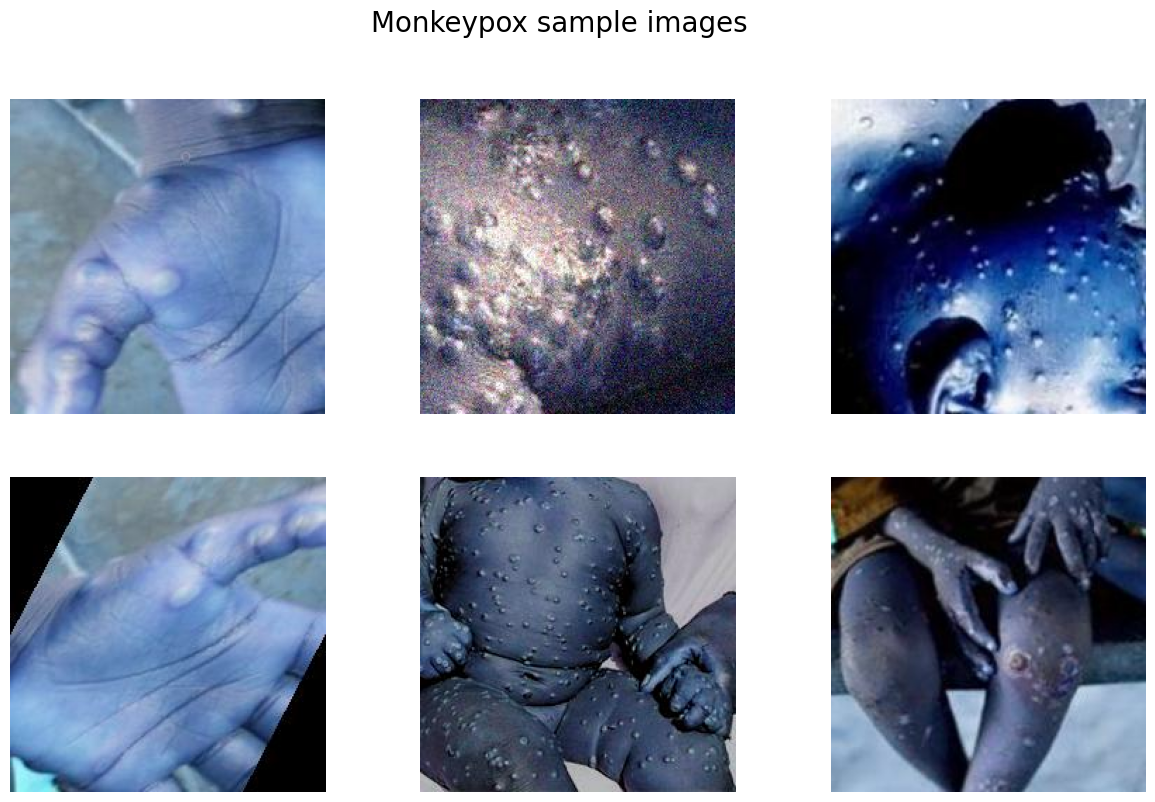

In [ ]:
sample_monkeypox = random.sample(Mimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread(M_DIR +sample_monkeypox[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Monkeypox sample images',fontsize=20)
plt.show()

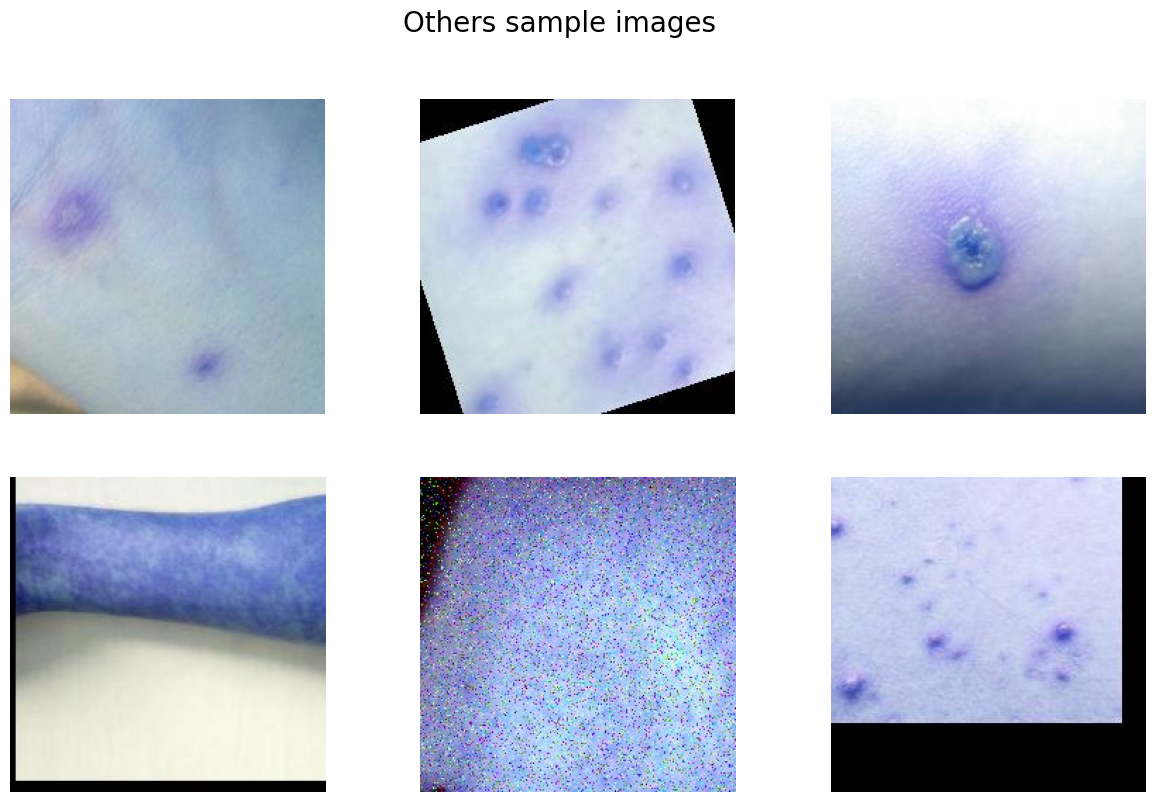

In [ ]:
sample_others = random.sample(Oimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread(O_DIR +sample_others[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Others sample images',fontsize=20)
plt.show()

In [ ]:
# Step 5: Prepare the dataset
data = []
labels = []

# Process Monkeypox images
for m in Mimages:
    try:
        image = cv2.imread(M_DIR + m)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(1)  # Label 1 for Monkeypox
    except AttributeError:
        print("")

# Process Other images
for o in Oimages:
    try:
        image = cv2.imread(O_DIR + o)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(0)  # Label 0 for Others
    except AttributeError:
        print("")

In [ ]:
feats = np.array(data)
labels = np.array(labels)

# Shuffle the dataset
s = np.arange(feats.shape[0])
np.random.shuffle(s)
feats, labels = feats[s], labels[s]

# One-hot encoding for labels
num_classes = len(np.unique(labels))

In [ ]:
# Step 6: Split dataset into train, validation, and test sets
split_1 = int(0.7 * len(feats))  # 70% for training
split_2 = int(0.85 * len(feats))  # 15% for validation, 15% for test

x_train = feats[:split_1].astype('float32') / 255
x_val = feats[split_1:split_2].astype('float32') / 255
x_test = feats[split_2:].astype('float32') / 255

y_train = to_categorical(labels[:split_1], num_classes)
y_val = to_categorical(labels[split_1:split_2], num_classes)
y_test = to_categorical(labels[split_2:], num_classes)

In [ ]:
# Step 7: Set Hyperparameters
epochs = 20
batch_size = 32

In [ ]:
# Step 8: Apply MobileNetV2
conv_base = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

for layer in conv_base.layers:
    layer.trainable = True  # Fine-tune all layers

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Add custom layers on top of MobileNetV2
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
predictions = layers.Dense(2, activation='softmax')(x)  # Binary classification

In [ ]:
# Compile the model
model = Model(conv_base.input, predictions)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:

# Step 9: Callbacks for saving the best model and reducing learning rate on plateau
checkpoint = ModelCheckpoint('.mdl_wts_mobilenetv2.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_lr=0.0000001)
callbacks = [checkpoint, reduce_lr]

In [ ]:
# Step 10: Train the model using validation data
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7429 - loss: 0.5064
Epoch 1: val_accuracy improved from -inf to 0.49844, saving model to .mdl_wts_mobilenetv2.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 369s 7s/step - accuracy: 0.7439 - loss: 0.5048 - val_accuracy: 0.4984 - val_loss: 0.7834 - learning_rate: 0.0010
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8884 - loss: 0.2675
Epoch 2: val_accuracy improved from 0.49844 to 0.63240, saving model to .mdl_wts_mobilenetv2.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 334s 7s/step - accuracy: 0.8884 - loss: 0.2673 - val_accuracy: 0.6324 - val_loss: 1.9860 - learning_rate: 0.0010
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9245 - loss: 0.1957
Epoch 3: val_accuracy improved from 0.63240 to 0.64798, saving model to .mdl_wts_mobilenetv2.keras

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
47/47 ━━━━━━━━━━━━━━━━━━━━ 382s 7s/step - accuracy: 0.9245 - loss: 0.1957 - val_accuracy: 0.6480 - v

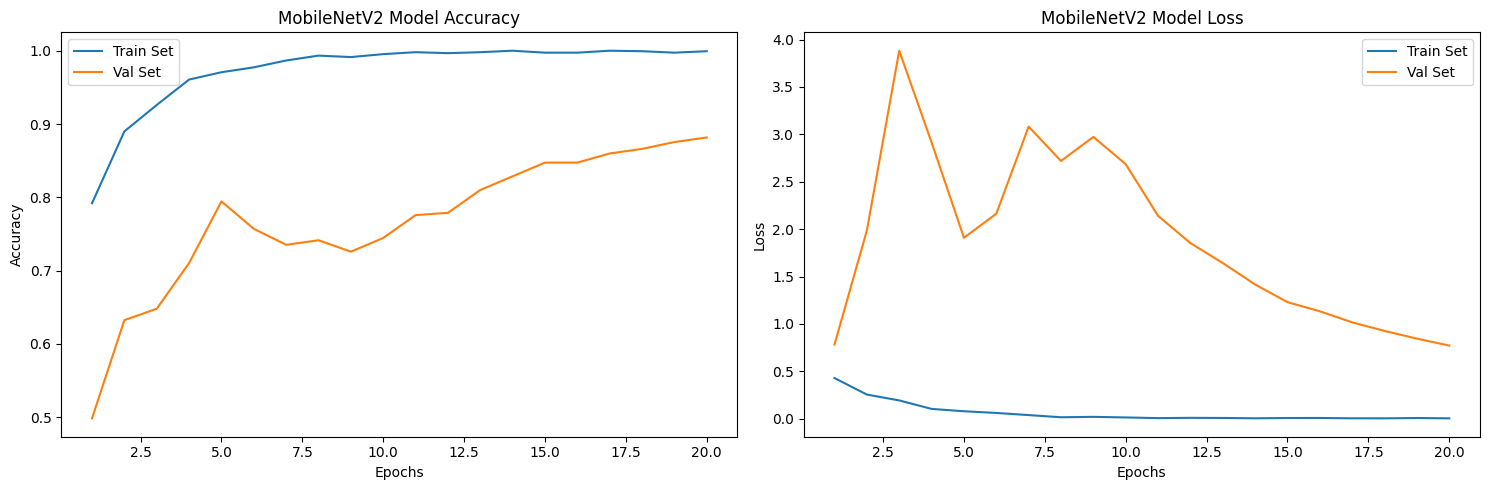

In [ ]:
# Step 11: Plotting accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MobileNetV2 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MobileNetV2 Model Loss')
plt.tight_layout()
plt.show()

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/Monkey_Pox_Dataset/MobileNetV2_MonkeyPox_Model.h5')

In [ ]:
# Step 12: Evaluate the model on the validation set
val_score = model.evaluate(x_val, y_val)
print('Validation Loss:', val_score[0])
print('Validation Accuracy:', val_score[1])

11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8666 - loss: 0.7722
Validation Loss: 0.7721025347709656
Validation Accuracy: 0.881619930267334


In [ ]:
# Step 13: Evaluate the model on the test set
test_score = model.evaluate(x_test, y_test)
print('Test Loss:', test_score[0])
print('Test Accuracy:', test_score[1])

11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9216 - loss: 0.4116
Test Loss: 0.4559862017631531
Test Accuracy: 0.9130434989929199


11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step


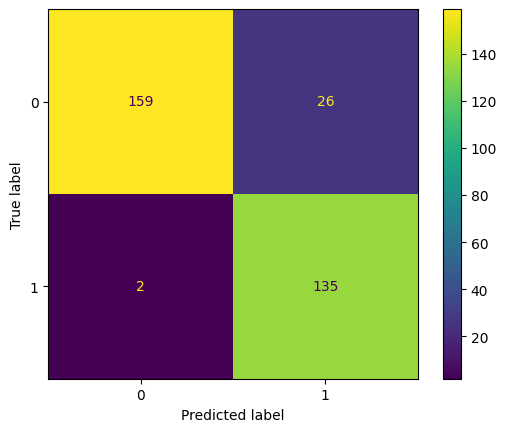

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.99      0.86      0.92       185
           1       0.84      0.99      0.91       137

    accuracy                           0.91       322
   macro avg       0.91      0.92      0.91       322
weighted avg       0.92      0.91      0.91       322



In [ ]:
# Step 14: Confusion matrix and classification report for test set
y_pred_test = model.predict(x_test)
y_pred_test = np.argmax(y_pred_test, axis=1)
y_true_test = np.argmax(y_test, axis=1)

CM_test = confusion_matrix(y_true_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=CM_test)
disp_test.plot()
plt.show()

print('Classification Report (Test Set):\n', classification_report(y_true_test, y_pred_test))

11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 970ms/step


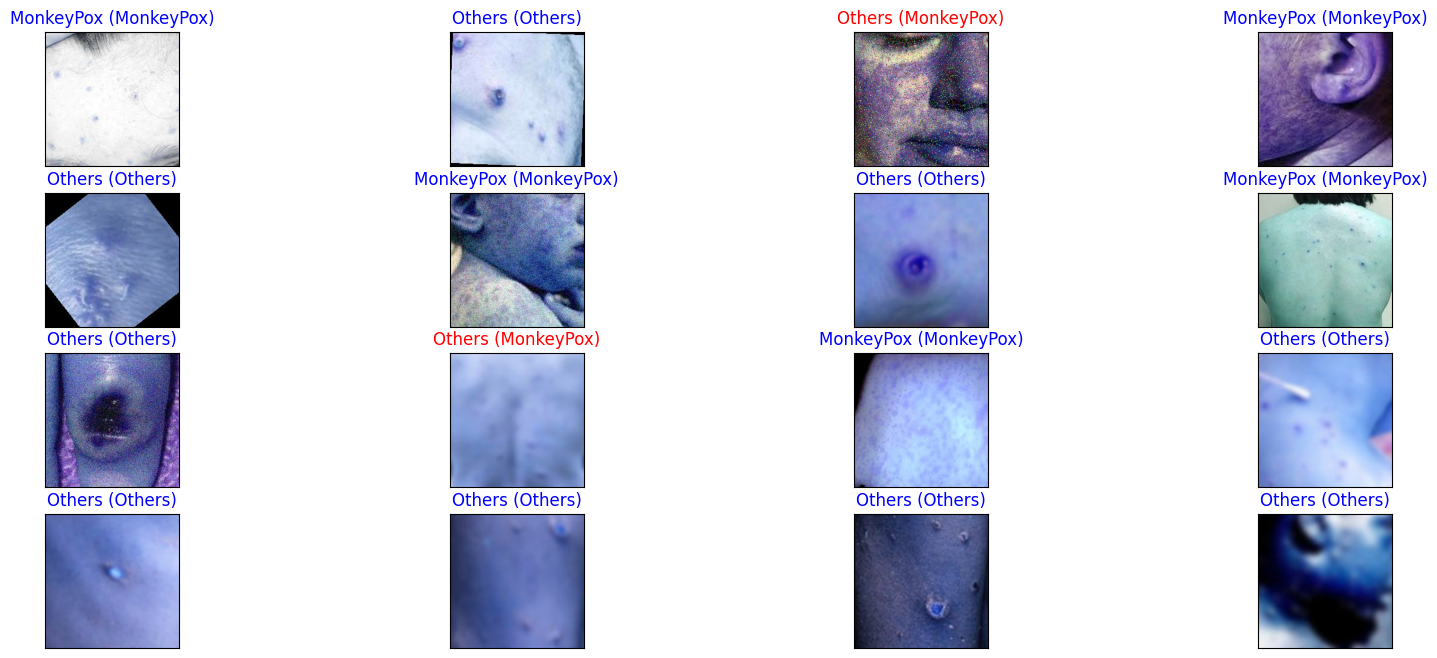

In [ ]:
# Step 15: Visualizing predictions on the test set
y_hat_test = model.predict(x_test)
labels_test = ['MonkeyPox', 'Others']

fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat_test[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(labels_test[pred_idx], labels_test[true_idx]),
                 color=("blue" if pred_idx == true_idx else "red"))
